# Fair GAN Implementation for Adult Census Dataset

## Setup and Installation

In [2]:
!pip install ucimlrepo
!pip install tensorflow>=2.4.0
!pip install aif360

zsh:1: 2.4.0 not found


In [4]:
import tensorflow as tf
import pandas as pd
import numpy as np
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from sklearn.preprocessing import StandardScaler, LabelEncoder
from ucimlrepo import fetch_ucirepo
import ssl
import warnings

ssl._create_default_https_context = ssl._create_unverified_context
warnings.filterwarnings('ignore')

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


## Fetch and prepare dataset

In [5]:
adult = fetch_ucirepo(id=2)
X = adult.data.features
y = adult.data.targets
y.columns = ['income']
full_data = pd.concat([X, y], axis=1)

print("Dataset shape:", full_data.shape)
print("\nColumns:", full_data.columns.tolist())

Dataset shape: (48842, 15)

Columns: ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']


## Preprocess dataset

In [6]:
def preprocess_data(df):
    df_copy = df.copy()
    
    # Binary operation for race (White vs Non-White)
    df_copy['race'] = df_copy['race'].apply(lambda x: 1 if x.strip() == 'White' else 0)

    categorical_features = ['workclass', 'education', 'marital-status', 'occupation',
                          'relationship', 'sex', 'native-country']
    
    numerical_features = ['age', 'fnlwgt', 'education-num', 'capital-gain',
                         'capital-loss', 'hours-per-week']
    
    label_encoders = {}
    for feature in categorical_features:
        label_encoders[feature] = LabelEncoder()
        df_copy[feature] = label_encoders[feature].fit_transform(df_copy[feature].astype(str))
    
    df_copy['income'] = df_copy['income'].apply(lambda x: 1 if x == '>50K' else 0)
    
    scaler = StandardScaler()
    df_copy[numerical_features] = scaler.fit_transform(df_copy[numerical_features])
    
    return df_copy, label_encoders, scaler

processed_data, label_encoders, scaler = preprocess_data(full_data)
print("\nRace distribution (White vs Non-White):")
print(processed_data['race'].value_counts(normalize=True).round(4))


Race distribution (White vs Non-White):
race
1    0.855
0    0.145
Name: proportion, dtype: float64


## GAN with fairness debiasing model

In [7]:
class GAN_with_FairnessDebiasing(tf.keras.Model):
    def __init__(self, input_dim, latent_dim=100, seed = 42):
        super(GAN_with_FairnessDebiasing, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.last_d_loss = 1.0
        self.seed = seed
        
        # Generator with conditioning
        # size of the input can be adjusted 
        self.generator = tf.keras.Sequential([
            tf.keras.layers.Dense(256, input_dim=latent_dim + 2),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            
            tf.keras.layers.Dense(512),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            
            tf.keras.layers.Dense(input_dim),
            tf.keras.layers.Activation('sigmoid')
        ])
        
        # Main discriminator
        self.discriminator = tf.keras.Sequential([
        tf.keras.layers.Dense(128, input_dim=input_dim, kernel_initializer=tf.keras.initializers.RandomUniform(minval=-0.1, maxval=0.1, seed=42)),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(0.3),
            
        tf.keras.layers.Dense(64),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.Dropout(0.3),
            
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
            
        # Fairness discriminator
        self.fairness_discriminator = tf.keras.Sequential([
            tf.keras.layers.Dense(128, input_dim=input_dim),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(64),
            tf.keras.layers.LeakyReLU(alpha=0.2),
            tf.keras.layers.Dense(2, activation='sigmoid')  # Changed to output 2 values for sex and race
        ])
        
        # Learning rate can be adjusted
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00002, beta_1=0.5)
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001, beta_1=0.5)
        self.f_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.5)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy()
    
            
    def demographic_parity_loss(self, data):
        # Extract protected features
        sex = data[:, 9:10]  
        race = data[:, 8:9]  
        protected_features = tf.concat([sex, race], axis=1)
        
        predictions = self.discriminator(data)
        
        # Calculate means for different demographic groups
        priv_mask = tf.reduce_all(tf.greater(protected_features, 0.5), axis=1)
        unpriv_mask = tf.reduce_all(tf.less_equal(protected_features, 0.5), axis=1)
        
        # Ensure mask has correct shape
        priv_mask = tf.reshape(priv_mask, [-1])
        unpriv_mask = tf.reshape(unpriv_mask, [-1])
        
        # Safe handling of empty groups
        priv_preds = tf.boolean_mask(predictions, priv_mask)
        unpriv_preds = tf.boolean_mask(predictions, unpriv_mask)
        
        priv_mean = tf.reduce_mean(priv_preds) if tf.size(priv_preds) > 0 else 0.0
        unpriv_mean = tf.reduce_mean(unpriv_preds) if tf.size(unpriv_preds) > 0 else 0.0
        
        return tf.abs(priv_mean - unpriv_mean)

    def equalized_odds_loss(self, data, labels):
        # Extract protected features
        sex = data[:, 9:10]  # sex column
        race = data[:, 8:9]  # race column
        protected_features = tf.concat([sex, race], axis=1)
        
        predictions = self.discriminator(data)
        
        # Ensure labels have correct shape
        labels = tf.cast(tf.reshape(labels, [-1, 1]), tf.float32)
        
        # Calculate true positive rates for different groups
        priv_mask = tf.reduce_all(tf.greater(protected_features, 0.5), axis=1)
        unpriv_mask = tf.reduce_all(tf.less_equal(protected_features, 0.5), axis=1)
        positive_mask = tf.reshape(tf.greater(labels, 0.5), [-1])
        
        # Safe handling of group intersections
        priv_pos_mask = tf.logical_and(priv_mask, positive_mask)
        unpriv_pos_mask = tf.logical_and(unpriv_mask, positive_mask)
        
        priv_pos_preds = tf.boolean_mask(predictions, priv_pos_mask)
        unpriv_pos_preds = tf.boolean_mask(predictions, unpriv_pos_mask)
        
        priv_tpr = tf.reduce_mean(priv_pos_preds) if tf.size(priv_pos_preds) > 0 else 0.0
        unpriv_tpr = tf.reduce_mean(unpriv_pos_preds) if tf.size(unpriv_pos_preds) > 0 else 0.0
        
        return tf.abs(priv_tpr - unpriv_tpr)

    def train_step(self, real_data):
        batch_size = tf.shape(real_data)[0]
        
        # Extract labels and protected attributes
        labels = real_data[:, -1]  # income is the last column
        protected_features = tf.concat([
            real_data[:, 9:10],
            real_data[:, 8:9]    
        ], axis=1)
        
        # Generate balanced conditions
        sex = tf.random.uniform([batch_size, 1], 0.4, 0.6) > 0.5
        race = tf.random.uniform([batch_size, 1], 0.4, 0.6) > 0.5
        conditions = tf.concat([tf.cast(sex, tf.float32), 
                              tf.cast(race, tf.float32)], axis=1)
        
        # Train Generator
        noise = tf.random.normal([batch_size, self.latent_dim])
        conditional_noise = tf.concat([noise, conditions], axis=1)
        
        with tf.GradientTape() as gen_tape:
            generated_data = self.generator(conditional_noise, training=True)
            fake_output = self.discriminator(generated_data, training=True)
            
            gen_loss = self.loss_fn(tf.ones_like(fake_output), fake_output)
            dp_loss = self.demographic_parity_loss(generated_data)
            eo_loss = self.equalized_odds_loss(generated_data, labels)
            
            fairness_weight = 0.5
            
            total_gen_loss = gen_loss + fairness_weight * (dp_loss + eo_loss)
        
        gen_grads = gen_tape.gradient(total_gen_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_grads, self.generator.trainable_variables))
        
        # Train Discriminator
        with tf.GradientTape() as disc_tape:
            generated_data = self.generator(conditional_noise, training=True)
            real_output = self.discriminator(real_data, training=True)
            fake_output = self.discriminator(generated_data, training=True)
            
            # These can be adjusted 
            real_labels = tf.random.uniform([batch_size, 1], 0.9, 0.95)
            fake_labels = tf.random.uniform([batch_size, 1], 0.0, 0.05)
            
            
            real_loss = self.loss_fn(real_labels, real_output)
            fake_loss = self.loss_fn(fake_labels, fake_output)
            disc_loss = (real_loss + fake_loss) / 2
            
            
            
            dp_reg = self.demographic_parity_loss(real_data)
            eo_reg = self.equalized_odds_loss(real_data, labels)
            total_disc_loss = disc_loss + fairness_weight * (dp_reg + eo_reg)
        
        
        
        #if total_disc_loss < 1.0:
        if disc_loss < 1.0:
            disc_grads = disc_tape.gradient(total_disc_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(disc_grads, self.discriminator.trainable_variables))
        
        # Train Fairness Discriminator
        with tf.GradientTape() as fair_tape:
            fair_pred_real = self.fairness_discriminator(real_data, training=True)
            fair_pred_fake = self.fairness_discriminator(generated_data, training=True)
            
            fair_loss = (self.loss_fn(protected_features, fair_pred_real) + 
                        self.loss_fn(conditions, fair_pred_fake)) / 2
        
        fair_grads = fair_tape.gradient(fair_loss, self.fairness_discriminator.trainable_variables)
        self.f_optimizer.apply_gradients(zip(fair_grads, self.fairness_discriminator.trainable_variables))
        
        return float(total_disc_loss.numpy()), float(total_gen_loss.numpy())

    def train(self, dataset, epochs=20, batch_size=10000):
        
        # Store these data into list for visualization
        d_losses = []
        g_losses = []
        
    
        dataset = tf.data.Dataset.from_tensor_slices(dataset).shuffle(10000).batch(batch_size)
        
        
        for epoch in range(epochs):
            
            
        
            total_d_loss = 0.0
            total_g_loss = 0.0
            num_batches = 0
            
            for batch in dataset:
                d_loss, g_loss = self.train_step(batch)
                total_d_loss += d_loss
                total_g_loss += g_loss
                num_batches += 1
            
            avg_d_loss = total_d_loss / num_batches
            avg_g_loss = total_g_loss / num_batches
            
            d_losses.append(avg_d_loss)
            g_losses.append(avg_g_loss)
            
            print(f"Epoch {epoch+1}/{epochs}, D Loss: {avg_d_loss:.4f}, G Loss: {avg_g_loss:.4f}")
        return d_losses, g_losses
    
    def generate_samples(self, num_samples):
        # Generate balanced conditions
        sex = np.random.binomial(1, 0.5, (num_samples, 1))
        race = np.random.binomial(1, 0.5, (num_samples, 1))
        conditions = np.concatenate([sex, race], axis=1)
        
        # Generate samples with conditions
        noise = tf.random.normal([num_samples, self.latent_dim])
        conditional_noise = tf.concat([noise, tf.convert_to_tensor(conditions, dtype=tf.float32)], axis=1)
        generated = self.generator(conditional_noise).numpy()
        
        # Create DataFrame
        generated_df = pd.DataFrame(generated, columns=processed_data.columns)
        
        # Ensure binary values
        binary_features = ['income', 'sex', 'race']
        for feature in binary_features:
            generated_df[feature] = (generated_df[feature] > 0.5).astype(float)
        
        return generated_df

## Train model

Starting training...
Epoch 1/30, D Loss: 0.9235, G Loss: 0.6356
Epoch 2/30, D Loss: 0.9265, G Loss: 0.6341
Epoch 3/30, D Loss: 0.9233, G Loss: 0.6325
Epoch 4/30, D Loss: 0.9250, G Loss: 0.6316
Epoch 5/30, D Loss: 0.9192, G Loss: 0.6300
Epoch 6/30, D Loss: 0.9213, G Loss: 0.6287
Epoch 7/30, D Loss: 0.9173, G Loss: 0.6270
Epoch 8/30, D Loss: 0.9191, G Loss: 0.6264
Epoch 9/30, D Loss: 0.9179, G Loss: 0.6259
Epoch 10/30, D Loss: 0.9152, G Loss: 0.6243
Epoch 11/30, D Loss: 0.9175, G Loss: 0.6236
Epoch 12/30, D Loss: 0.9141, G Loss: 0.6233
Epoch 13/30, D Loss: 0.9120, G Loss: 0.6221
Epoch 14/30, D Loss: 0.9076, G Loss: 0.6211
Epoch 15/30, D Loss: 0.9110, G Loss: 0.6201
Epoch 16/30, D Loss: 0.9062, G Loss: 0.6193
Epoch 17/30, D Loss: 0.9034, G Loss: 0.6189
Epoch 18/30, D Loss: 0.9038, G Loss: 0.6182
Epoch 19/30, D Loss: 0.9066, G Loss: 0.6165
Epoch 20/30, D Loss: 0.9048, G Loss: 0.6167
Epoch 21/30, D Loss: 0.9025, G Loss: 0.6152
Epoch 22/30, D Loss: 0.9006, G Loss: 0.6145
Epoch 23/30, D Loss:

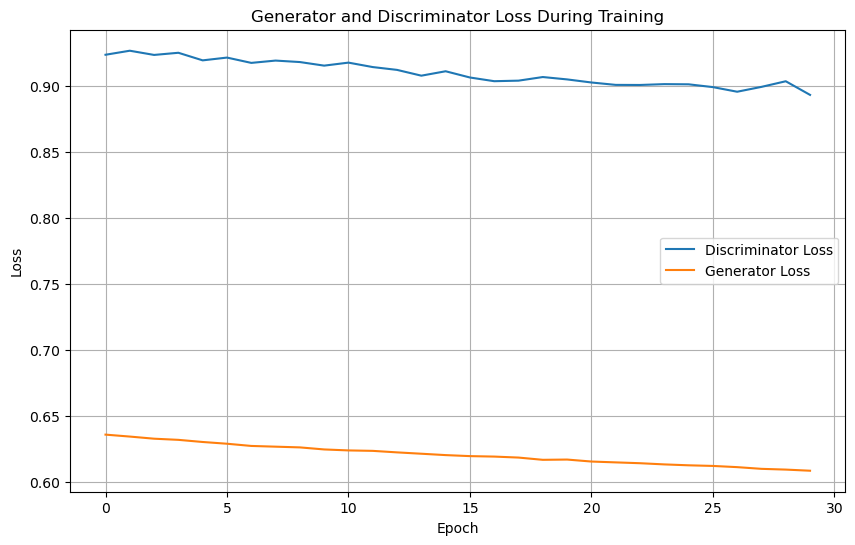

In [105]:
import matplotlib.pyplot as plt

# Initialize and train FairGAN
#gan = GAN_with_FairnessDebiasing(input_dim=processed_data.shape[1])
gan = GAN_with_FairnessDebiasing(input_dim=processed_data.shape[1])
print("Starting training...")
#gan.train(processed_data.values, epochs=100, batch_size=10000)

d_losses, g_losses = gan.train(processed_data.values, epochs=30, batch_size=10000)

# Plot diagram for visualization
plt.figure(figsize=(10, 6))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Generator and Discriminator Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Generate synthetic data

In [106]:
synthetic_samples = gan.generate_samples(48842)
synthetic_df = pd.DataFrame(synthetic_samples, columns=processed_data.columns)
print (synthetic_df.head())

        age  workclass    fnlwgt  education  education-num  marital-status  \
0  0.216018   0.414023  0.635514   0.835546       0.265847        0.652880   
1  0.392443   0.742560  0.687584   0.844270       0.366370        0.689484   
2  0.521861   0.777929  0.518473   0.852235       0.731954        0.312200   
3  0.781090   0.208566  0.781774   0.840202       0.695504        0.382982   
4  0.299741   0.184965  0.716782   0.487733       0.713977        0.570622   

   occupation  relationship  race  sex  capital-gain  capital-loss  \
0    0.230752      0.370998   1.0  0.0      0.374453      0.315435   
1    0.555626      0.529275   1.0  0.0      0.466761      0.536653   
2    0.829452      0.246493   1.0  1.0      0.536394      0.103545   
3    0.312136      0.162119   1.0  1.0      0.408111      0.289999   
4    0.649622      0.314508   1.0  1.0      0.602631      0.641205   

   hours-per-week  native-country  income  
0        0.372408        0.753598     1.0  
1        0.369478     

## Evaluate Fairness and Visuaization

In [107]:
def evaluate_fairness(dataset, protected_attribute):
    # Get data distributions
    df = dataset.convert_to_dataframe()[0]
    
    # Get overall positive outcome rates for privileged and unprivileged groups
    privileged_mask = (df[protected_attribute] == 1)
    unprivileged_mask = (df[protected_attribute] == 0)
    
    priv_outcome_rate = df[privileged_mask]['income'].mean()
    unpriv_outcome_rate = df[unprivileged_mask]['income'].mean()
    
    # Calculate metrics
    disparate_impact = unpriv_outcome_rate / priv_outcome_rate if priv_outcome_rate != 0 else 0
    statistical_parity = unpriv_outcome_rate - priv_outcome_rate
    print(disparate_impact)
    print(statistical_parity)
    
# Create AIF360 dataset with label specifications
aif_dataset = BinaryLabelDataset(
    df=processed_data,
    label_names=['income'],
    protected_attribute_names=['sex', 'race'],
    privileged_protected_attributes=[1, 1],
    favorable_label=1,
    unfavorable_label=0
)


evaluate_fairness(aif_dataset, 'sex')
evaluate_fairness(aif_dataset, 'race')

synthetic_df['income'] = synthetic_df['income'].round().clip(0, 1).astype(int)
synthetic_df['sex'] = synthetic_df['sex'].round().clip(0, 1).astype(int)       
synthetic_df['race'] = synthetic_df['race'].round().clip(0, 1).astype(int)     

synthetic_aif_dataset = BinaryLabelDataset(
    df=synthetic_df,
    label_names=['income'],
    protected_attribute_names=['sex', 'race'],
    privileged_protected_attributes=[1, 1],
    favorable_label=1,
    unfavorable_label=0
)

evaluate_fairness(synthetic_aif_dataset, 'sex')
evaluate_fairness(synthetic_aif_dataset, 'race')

0.356855066580203
-0.13122914384204248
0.6000530281199865
-0.0681581964194736
1.025194274882217
0.01460201977906972
0.9877485092743193
-0.007172684576496113


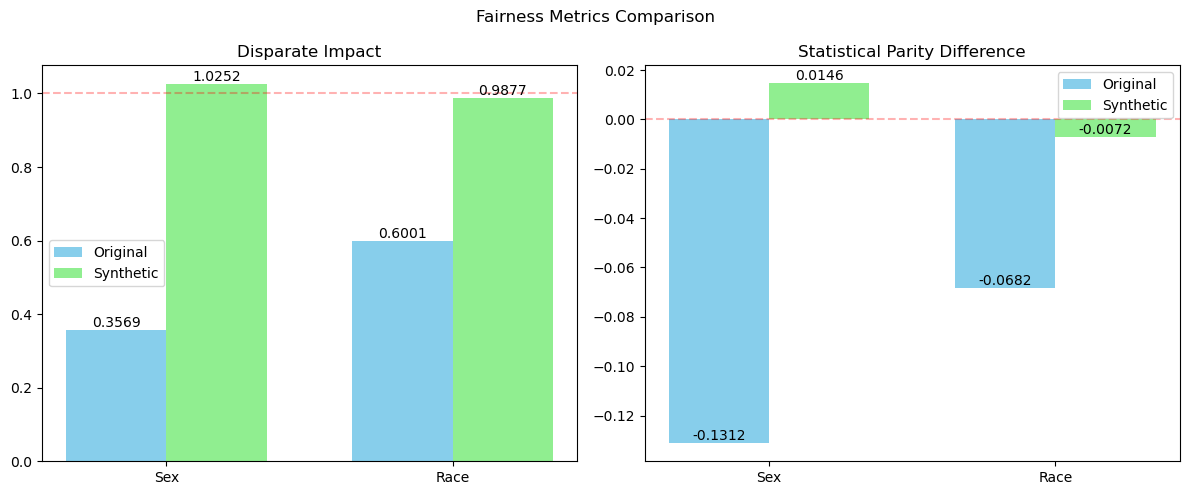

In [108]:
def visualize_fairness_metrics(metrics_original_sex, metrics_original_race, 
                             metrics_synthetic_sex, metrics_synthetic_race):

    metrics_data = {
        'sex': {
            'Original DI': metrics_original_sex.disparate_impact(),
            'Original SPD': metrics_original_sex.statistical_parity_difference(),
            'Synthetic DI': metrics_synthetic_sex.disparate_impact(),
            'Synthetic SPD': metrics_synthetic_sex.statistical_parity_difference()
        },
        'race': {
            'Original DI': metrics_original_race.disparate_impact(),
            'Original SPD': metrics_original_race.statistical_parity_difference(),
            'Synthetic DI': metrics_synthetic_race.disparate_impact(),
            'Synthetic SPD': metrics_synthetic_race.statistical_parity_difference()
        }
    }
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle('Fairness Metrics Comparison')
    
    # Plot Disparate Impact
    x = np.arange(2)
    width = 0.35
    
    ax1.bar(x - width/2, [metrics_data['sex']['Original DI'], metrics_data['race']['Original DI']], 
            width, label='Original', color='skyblue')
    ax1.bar(x + width/2, [metrics_data['sex']['Synthetic DI'], metrics_data['race']['Synthetic DI']], 
            width, label='Synthetic', color='lightgreen')
    
    ax1.set_title('Disparate Impact')
    ax1.set_xticks(x)
    ax1.set_xticklabels(['Sex', 'Race'])
    ax1.axhline(y=1.0, color='r', linestyle='--', alpha=0.3)
    ax1.legend()
    
    # Plot Statistical Parity Difference
    ax2.bar(x - width/2, [metrics_data['sex']['Original SPD'], metrics_data['race']['Original SPD']], 
            width, label='Original', color='skyblue')
    ax2.bar(x + width/2, [metrics_data['sex']['Synthetic SPD'], metrics_data['race']['Synthetic SPD']], 
            width, label='Synthetic', color='lightgreen')
    
    ax2.set_title('Statistical Parity Difference')
    ax2.set_xticks(x)
    ax2.set_xticklabels(['Sex', 'Race'])
    ax2.axhline(y=0.0, color='r', linestyle='--', alpha=0.3)
    ax2.legend()
    
    for rect in ax1.patches:
        height = rect.get_height()
        ax1.text(rect.get_x() + rect.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')

    for rect in ax2.patches:
        height = rect.get_height()
        ax2.text(rect.get_x() + rect.get_width()/2., height,
                 f'{height:.4f}',
                 ha='center', va='bottom')
        
    plt.tight_layout()
    plt.show()

# Create metrics objects
metrics_original_sex = BinaryLabelDatasetMetric(
    aif_dataset,
    unprivileged_groups=[{'sex': 0}],
    privileged_groups=[{'sex': 1}]
)
metrics_original_race = BinaryLabelDatasetMetric(
    aif_dataset,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)
metrics_synthetic_sex = BinaryLabelDatasetMetric(
    synthetic_aif_dataset,
    unprivileged_groups=[{'sex': 0}],
    privileged_groups=[{'sex': 1}]
)
metrics_synthetic_race = BinaryLabelDatasetMetric(
    synthetic_aif_dataset,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)

# Only visualize fairness metrics
visualize_fairness_metrics(metrics_original_sex, metrics_original_race, 
                         metrics_synthetic_sex, metrics_synthetic_race)

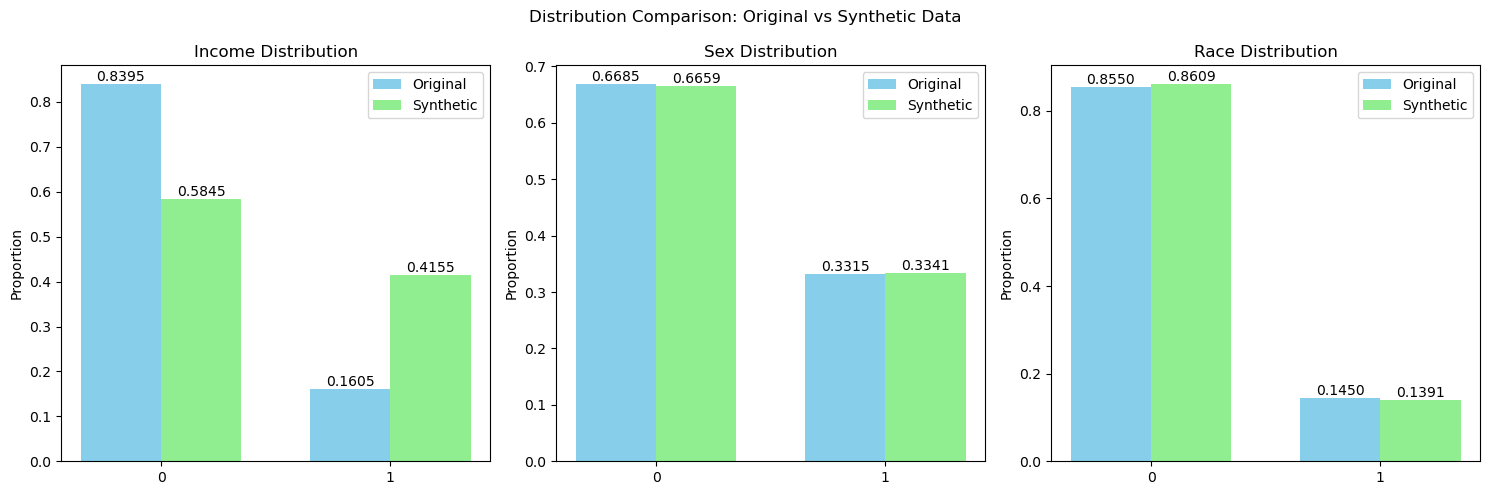


=== Distribution Data ===

Income Distribution:
Original:  [0.8394619384955571, 0.16053806150444289]
Synthetic: [0.5844560009827607, 0.41554399901723926]

Sex Distribution:
Original:  [0.6684820441423365, 0.33151795585766347]
Synthetic: [0.6658613488391139, 0.33413865116088615]

Race Distribution:
Original:  [0.855042791040498, 0.14495720895950207]
Synthetic: [0.8608574587445231, 0.13914254125547684]


In [109]:
def visualize_distributions(original_dataset, synthetic_dataset):
    # Store the distributions data
    distribution_data = {
        'original': {},
        'synthetic': {}
    }
    
    # Convert AIF360 datasets back to pandas dataframes
    original_data = original_dataset.convert_to_dataframe()[0]
    synthetic_data = synthetic_dataset.convert_to_dataframe()[0]
    
    # Set up the figure
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Distribution Comparison: Original vs Synthetic Data')
    
    # Data to plot
    features = ['income', 'sex', 'race']
    titles = ['Income Distribution', 'Sex Distribution', 'Race Distribution']
    
    # Plot each distribution
    for idx, (feature, title) in enumerate(zip(features, titles)):
        orig_dist = original_data[feature].value_counts(normalize=True)
        syn_dist = synthetic_data[feature].value_counts(normalize=True)
        
        # Store the distributions
        distribution_data['original'][feature] = orig_dist.values.tolist()
        distribution_data['synthetic'][feature] = syn_dist.values.tolist()
        
        x = np.arange(2)
        width = 0.35
        
        axes[idx].bar(x - width/2, orig_dist, width, label='Original', color='skyblue')
        axes[idx].bar(x + width/2, syn_dist, width, label='Synthetic', color='lightgreen')
        
        axes[idx].set_title(title)
        axes[idx].set_xticks(x)
        axes[idx].set_xticklabels(['0', '1'])
        axes[idx].set_ylabel('Proportion')
        axes[idx].legend()
        
        # Add value labels on bars
        for i, v in enumerate(orig_dist):
            axes[idx].text(i - width/2, v, f'{v:.4f}', ha='center', va='bottom')
        for i, v in enumerate(syn_dist):
            axes[idx].text(i + width/2, v, f'{v:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()
    
    return distribution_data

# Function to print the stored data
def print_distribution_data(distribution_data):
    print("\n=== Distribution Data ===")
    
    for feature in ['income', 'sex', 'race']:
        print(f"\n{feature.capitalize()} Distribution:")
        print(f"Original:  {distribution_data['original'][feature]}")
        print(f"Synthetic: {distribution_data['synthetic'][feature]}")

# Modified usage:
distribution_data = visualize_distributions(aif_dataset, synthetic_aif_dataset)
print_distribution_data(distribution_data)

In [110]:
def calculate_model_accuracy(distribution_data):

    accuracies = {}
    
    # Calculate accuracy for each feature
    for feature in ['income', 'sex', 'race']:
        original = np.array(distribution_data['original'][feature])
        synthetic = np.array(distribution_data['synthetic'][feature])
        
        # Calculate accuracy as 1 - mean absolute difference
        accuracy = 1 - np.mean(np.abs(original - synthetic))
        accuracies[feature] = accuracy
    
    # Calculate overall accuracy
    overall_accuracy = np.mean([accuracies[feature] for feature in accuracies])
    accuracies['overall'] = overall_accuracy
    
    return accuracies

def print_accuracy_report(accuracies):

    print("\n=== Model Accuracy Analysis ===")
    print(f"{'Feature':<15} {'Accuracy':>10}")
    print("-" * 25)
    
    for feature in ['income', 'sex', 'race']:
        print(f"{feature:<15} {accuracies[feature]:>10.4f}")
    
    print("-" * 25)
    print(f"{'Overall':<15} {accuracies['overall']:>10.4f}")

# Usage (after getting distribution_data):
accuracies = calculate_model_accuracy(distribution_data)
print_accuracy_report(accuracies)


=== Model Accuracy Analysis ===
Feature           Accuracy
-------------------------
income              0.7450
sex                 0.9974
race                0.9942
-------------------------
Overall             0.9122


## Save preprocessed and synthetic datasets

In [25]:
import os
def save_synthetic_data(df, folder_path, filename):
    # Create all necessary directories in the path
    os.makedirs(folder_path, exist_ok=True)
    counter = 1
    name, ext = os.path.splitext(filename)
    
    # Keep incrementing counter until we find an unused filename
    while True:
        new_filename = f"{name}_{counter}{ext}"
        file_path = os.path.join(folder_path, new_filename)
        
        if not os.path.exists(file_path):
            df.to_csv(file_path, index=False)
            print(f"Data saved successfully to {file_path}")
            break
            
        counter += 1

In [26]:
output_datasets_folder = 'output_datasets'

synthetic_data_output_folder = os.path.join(output_datasets_folder, 'synthetic_adult')
synthetic_data_output_filename = 'synthetic_adult.txt'

preprocessed_data_output_folder = os.path.join(output_datasets_folder, 'preprossed_adult')
preprocessed_data_output_filename = 'preprossed_adult.txt'

save_synthetic_data(synthetic_df, synthetic_data_output_folder, synthetic_data_output_filename)
save_synthetic_data(processed_data, preprocessed_data_output_folder, preprocessed_data_output_filename)
print("Synthetic Dataset shape:", synthetic_df.shape)
print("Preprocessed Dataset shape:", processed_data.shape)

Data saved successfully to output_datasets/synthetic_adult/synthetic_adult_6.txt
Data saved successfully to output_datasets/preprossed_adult/preprossed_adult_6.txt
Synthetic Dataset shape: (48842, 15)
Preprocessed Dataset shape: (48842, 15)
